In [1]:
import pandas as pd
import numpy as np
import duckdb
query = 'SET enable_progress_bar = false;'
duckdb.sql(query)

import kagglehub
path = kagglehub.dataset_download("figshare/united-states-commutes")
print("Path to dataset files:", path)

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Path to dataset files: /Users/kaveh/.cache/kagglehub/datasets/figshare/united-states-commutes/versions/2


In [2]:
# Load in datasets.
commute_data = duckdb.read_csv(path + '/commute_data.csv')
# Each row lists a pair of census tracts, plus the number of commutes from the origin tract to the destination tract.
# Each census tract is identified by a numeric "FIPS code". Each state recieves a two-digit code; each county
# in that state recieves a three-digit code; and each individual tract receives a 6 digit code. 
# The full FIPS code for an individual census tract is obtained by concatenating these codes.
tract_reference = duckdb.read_csv(path + '/census_tracts_2010.csv')
# Contains geographical data for each tract, most significantly for us - latitude and longitude.

In [3]:
CA_FIPS_code = 6
valley_counties_FIPS = [89, # Shasta
                    103, # Tehama
                    21, # Glenn
                    7, # Butte
                    11, # Colusa
                    101, # Sutter
                    115, # Yuba
                    113, # Yolo
                    61, # Placer
                    67, # Sacramento
                    77, # San Joaquin
                    95, # Solano
                    99, # Stanislaus
                    47, # Merced
                   39, # Madera
                   19, # Fresno
                   31, # Kings
                   107, # Tulare
                   29, # Kern
                   ]

# We define the Central Valley to consist of the above counties, excluding the following areas:
## Solano County south of Cordelia (38.16 degrees latitude) (Excludes portions of the North Bay Area, such as Vallejo)
## Placer County east of Auburn (-121.04 degrees longitude) (Excludes communities in the Sierra Nevada / Lake Tahoe area)
## Kern County east of Tehachapi (-118.41 degrees longitude) (Excludes communities in the Mojave Desert, such as Ridgecrest)

query = """
SELECT c.ofips, c.dfips, c.octfips, c.dctfips, c.flow, 
origin.intptlat AS olat, origin.intptlong AS olong, 
dest.intptlat AS dlat, dest.intptlong AS dlong 
FROM commute_data AS c 
LEFT JOIN tract_reference AS origin ON c.ofips = origin.geoid 
LEFT JOIN tract_reference AS dest ON c.dfips = dest.geoid
WHERE 
(c.ostfips = {fstate} AND c.dstfips = {fstate}) -- originating and ending in CA
AND (c.octfips IN {fcounty} AND c.dctfips IN {fcounty}) -- originating and ending in our list of counties
AND NOT c.ofips = c.dfips -- exclude trips within the same census tract
""".format(fstate = CA_FIPS_code, fcounty = str(valley_counties_FIPS))

# We leave the lat/long filtering to do with pandas - the format of the longitude in the tract_reference file confuses SQL when 
# I try to cast it to a float. Pandas seems to do much better.
# Likely something to do with the formatting of the minus sign.
commute_data_valley = duckdb.sql(query)
df = commute_data_valley.df()
df['olong'] = df['olong'].astype(float)
df['dlong'] = df['dlong'].astype(float)
df


,OFIPS,DFIPS,OCTFIPS,DCTFIPS,FLOW,olat,olong,dlat,dlong
0,06007000102,06067005804,7,67,20,39.757866,-121.823520,38.586368,-121.339443
1,06007000103,06007000603,7,7,90,39.768060,-121.818560,39.736894,-121.849587
2,06007000104,06007001500,7,7,20,39.767077,-121.837529,39.596931,-121.841582
3,06007000201,06077000600,7,77,20,39.775401,-121.863804,37.948346,-121.273111
4,06007000202,06101050201,7,101,20,39.763856,-121.849496,39.134161,-121.628638
...,...,...,...,...,...,...,...,...,...
71166,06115040700,06067001101,115,67,65,39.017754,-121.553110,38.577207,-121.490463
71167,06115040700,06061020717,115,61,65,39.017754,-121.553110,38.752350,-121.245496
71168,06115040700,06067005502,115,67,50,39.017754,-121.553110,38.604627,-121.427003
71169,06115040700,06067002100,115,67,50,39.017754,-121.553110,38.569333,-121.506366


In [4]:
def latlongfilter(row, county_fips, latlong, threshold, bigger):
    # Takes as input a row of the dataframe returned in the above query.
    # Returns False if either the origin or destination census tract lie in the provided county, but outside of the
    # latitude/longitude cutoff. Returns True otherwise.
    # latlong: string, either "lat" or "long". Determines whether to filter on latitude or longitude.
    # threshold: float, specifying the cutoff value.
    # bigger: boolean. If True, bigger lat/long values will pass the cutoff. If False, smaller ones will.
    origin_in_county = (county_fips == row['OCTFIPS'])
    dest_in_county = (county_fips == row['DCTFIPS'])
    if origin_in_county:
        ocoord = row['o{}'.format(latlong)]
        if bigger:
            opassed = ocoord >= threshold
        else:
            opassed = ocoord < threshold
    else:
        opassed = True
    
    if dest_in_county:
        dcoord = row['d{}'.format(latlong)]
        if bigger:
            dpassed = dcoord >= threshold
        else:
            dpassed = dcoord < threshold
    else:
        dpassed = True
    
    return (dpassed and opassed)

df = df[df.apply(lambda x : latlongfilter(x, 95, 'lat', 38.16, True), axis=1)] # Filter out southern Solano County
df = df[df.apply(lambda x : latlongfilter(x, 61, 'long', -121.04, False), axis=1)] # Filter out eastern Placer County
df = df[df.apply(lambda x : latlongfilter(x, 29, 'long', -118.41, False), axis=1)] # Filter out estern Kern County

df.to_csv('commute_data_valley.csv')

# We are now done with all columns but the OFIPS, DFIPS, and FLOW columns. Discard everything else.
df = df[['OFIPS', 'DFIPS', 'FLOW']]

In [5]:
# We now need to build a distance matrix, assigning each pair of census tracts a distance based on the commuter flow between them.
# Higher commuter flow = shorter distance, while lower commuter flow = larger distance.
# We start by assigning to each pair of census tracts the total commuter flow between them.

def update_matrix(row, flow_matrix):
    # Given a row (representing a commuter flow) from the source dataframe, adds that flow to the flow matrix.
    ofips = row['OFIPS']
    dfips = row['DFIPS']
    flow = row['FLOW']
    flow_matrix.loc[ofips, dfips] += flow
    flow_matrix.loc[dfips, ofips] += flow

# Build the flow matrix
unique_tracts = np.unique(np.concatenate((df['OFIPS'].unique(), df['DFIPS'].unique())))
n = len(unique_tracts)

flow_matrix = -1*np.identity(n) # We say a census tract has flow -1 to itself, as a flag for later when we turn flows into distances.
flow_matrix = pd.DataFrame(flow_matrix, index=unique_tracts, columns=unique_tracts)
df.apply(lambda x : update_matrix(x, flow_matrix), axis=1)

flow_matrix.to_csv('flow_matrix.csv')
    

In [6]:
# To convert commuter flows to distances, we just take the reciprocal. (We add 1 to each flow to ensure we avoid division by 0.)
# Census tracts with no flow between them will have distance 1, and increased flow will decrease the distance.
def distance_from_flow(x):
    if x >= 0:
        return (1 / (1 + x))
    elif x == -1:
        return 0
    else:
        raise ValueError('Negative flow')
    
distance_matrix = flow_matrix.map(lambda x : distance_from_flow(x))

In [7]:
# Stick our list of census tracts appearing in our dataset into a DataFrame, so we can query it with duckdb.
unique_tracts_df = pd.DataFrame(np.transpose(unique_tracts), columns=['FIPS'])
# Bring back the latitude and longitude data.
query = """
SELECT u.FIPS, t.intptlat, t.intptlong
FROM unique_tracts_df AS u LEFT JOIN tract_reference AS t ON u.FIPS = t.GEOID
"""
tracts_latlong = duckdb.sql(query)
final_df = tracts_latlong.df()
final_df = final_df.set_index('FIPS')
final_df['INTPTLONG'] = final_df['INTPTLONG'].astype(float)

# For k between 2 and 40, generate a clustering of the census tracts into k classes.
num_classes = 40
klist = range(2, num_classes)
scores = []
for k in klist:
    cluster = AgglomerativeClustering(n_clusters = k, metric='precomputed', linkage='average')
    classes = cluster.fit_predict(distance_matrix)
    col_label = '{} classes'.format(k)
    final_df[col_label] = classes
    scores.append(silhouette_score(distance_matrix, classes))

scores_df = pd.DataFrame({'k' : klist, 'scores' : scores})
scores_df.set_index('k')
scores_df.to_csv('Silhouette_scores.csv')
final_df.to_csv('Census_tract_classification.csv')

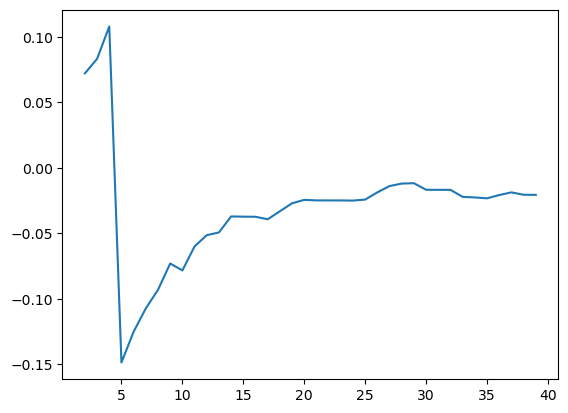

In [8]:
# The silhoutte score of a clustering measures the quality of a clustering by comparing the distance between a data point and 
# the members of its cluster, and its distance to other data points outside of its cluster.
# It ranges between -1 and 1.
plt.plot(scores_df['k'], scores_df['scores'])

In [9]:
def plot_on_map(k, df):
    # Takes as input a dataframe including the census tracts, with lat/long position, and their classifications, as well as a number
    # k for how many clusters to consider.
    # Plots the clusters on a map, and then returns just the dataframe with the requested number of clusters.
    col_name = '{} classes'.format(k)
    labels = df[col_name]
    lat = df['INTPTLAT']
    long = df['INTPTLONG']
    fig, ax = plt.subplots(figsize = (20, 10))
    m = Basemap(projection='cyl',llcrnrlat=34,urcrnrlat=42,\
            llcrnrlon=-123,urcrnrlon=-117,lat_ts=36, resolution='f', ax=ax)
    m.arcgisimage()
    x, y = m(long, lat)
    m.scatter(x, y, c=labels, cmap='PiYG', s=2.5, alpha=1)
    plt.show()

    return df[['INTPTLAT', 'INTPTLONG', col_name]]

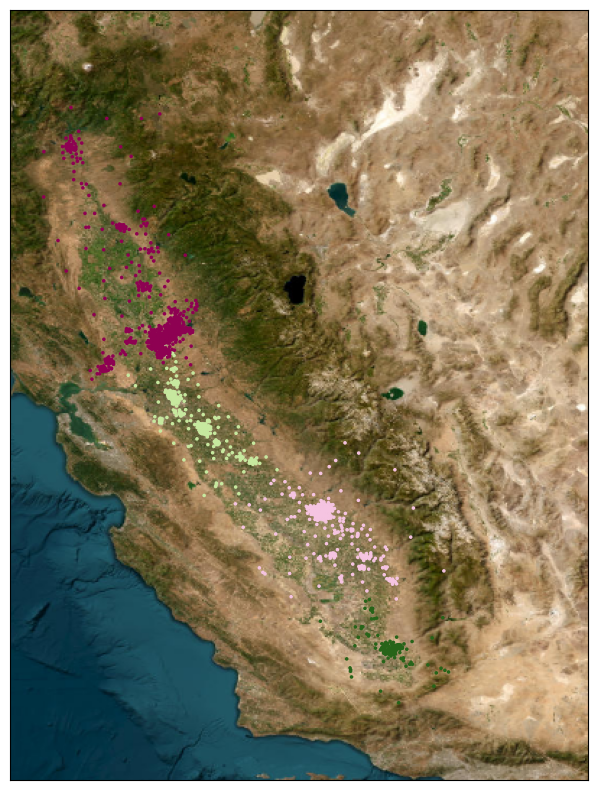

4 classes
0    627
1    323
2    295
3    135
Name: count, dtype: int64

In [10]:
plot_on_map(4, final_df)
final_df['4 classes'].value_counts()

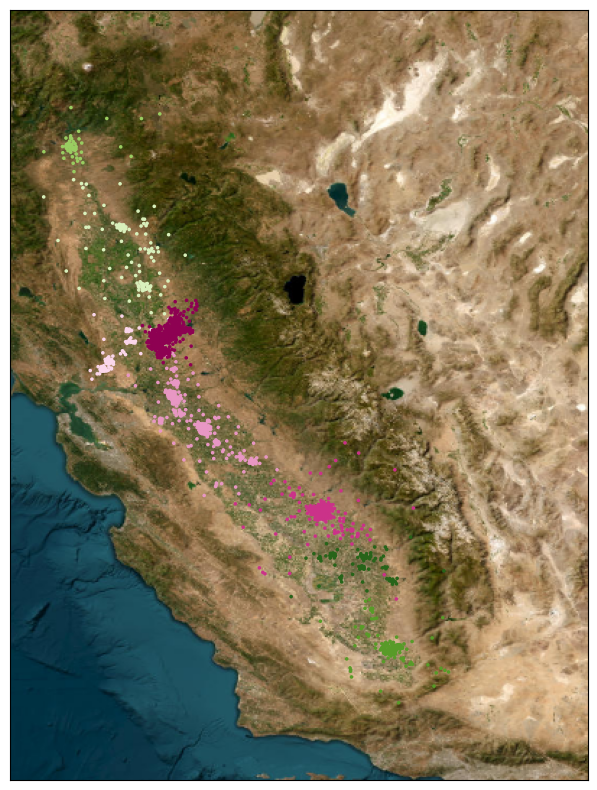

9 classes
0    381
2    295
1    231
7    135
5    108
8     92
3     88
6     49
4      1
Name: count, dtype: int64

In [11]:
plot_on_map(9, final_df)
final_df['9 classes'].value_counts()

In [12]:
# The single isolated data point is very odd. It's a single census tract in Roseville, which
# by the eye test really should be grouped with Sacramento.
k9 = final_df[['INTPTLAT', 'INTPTLONG', '9 classes']]
k9[k9['9 classes'] == 4]

,INTPTLAT,INTPTLONG,9 classes
FIPS,,,
06061021039,38.784613,-121.352057,4


In [13]:
# Looking at the flow matrix for this tract, we can see that it mainly connects to nearby census tracts - only one tract it
# connects to is not in the same county. It's a mystery to me why the algorithm decides to wait so long to merge this tract
# with the Sacramento cluster.
flow_matrix['06061021039'][flow_matrix['06061021039'] > 0]

06061020908    20.0
06061021003    30.0
06061021040     4.0
06061021043    20.0
06061021106    10.0
06061021108    10.0
06061021403    25.0
06101050800    10.0
Name: 06061021039, dtype: float64